In [1]:
from paretoGraphInfluence import *
import shutil
import matplotlib as mpl

# Enable LaTeX rendering if available (fallback to Matplotlib text otherwise)
if shutil.which("latex"):
    mpl.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}",
    })
else:
    mpl.rcParams.update({"text.usetex": False})

# Import influence datasets
data_path_HEPT = '../../datasets/raw_data/influence/NetHEPT/hep.txt'
data_path_PHY = '../../datasets/raw_data/influence/NetPHY/phy.txt'

G_HEPT = import_influence_data(data_path_HEPT)
G_PHY = import_influence_data(data_path_PHY)

2026-02-04 20:17:54,511 |INFO: Imported influence graph with 1673 nodes and 3863 edges
2026-02-04 20:17:56,138 |INFO: Imported influence graph with 912 nodes and 8748 edges


In [ ]:
def findApproximateParetoSolutionsInfluenceGraph(G, num_samples=10, num_runs=5, sample_size=200, maxDiameter=None, dataset_name=""):
    '''
    Run graph-diameter algorithms over multiple runs and plot mean +/- std (Influence vs Diameter).
    Parameters:
    - G: Graph
    - num_samples: Number of Monte Carlo samples per run
    - num_runs: Number of independent runs
    - sample_size: Optional node subsample size
    - maxDiameter: Optional diameter max for plotting grid
    - dataset_name: Name of the dataset for plotting
    '''
    algo_names = ["ParetoGreedy-Diameter", "PlainGreedy", "TopK-degree", "PruneGraph"]

    all_influences = {alg: [] for alg in algo_names}
    all_runtimes = {alg: [] for alg in algo_names}
    pareto_diams_all = []
    pareto_points_counts = []

    for run_idx in range(num_runs):
        subG, sub_nodes = sample_graph(G, sample_size=sample_size, seed=run_idx)
        pairwise_costs, sub_nodes = compute_pairwise_costs_from_graph(subG, sub_nodes)

        if maxDiameter is None:
            maxDiameter_run = 1.5 * float(np.max(pairwise_costs)) if pairwise_costs.size > 0 else 1.0
        else:
            maxDiameter_run = maxDiameter

        num_steps, min_diameter = 15, 0.0
        diameter_arr = np.linspace(min_diameter, maxDiameter_run, num_steps)

        def align_to_diameter_arr(diameters, infls):
            if len(diameters) == 0 or len(infls) == 0:
                return np.full_like(diameter_arr, np.nan, dtype=float)
            diameters = np.array(diameters, dtype=float)
            infls = np.array(infls, dtype=float)
            min_len = min(len(diameters), len(infls))
            diameters = diameters[:min_len]
            infls = infls[:min_len]
            agg = {}
            for d, c in zip(diameters, infls):
                if d in agg:
                    agg[d] = max(agg[d], c)
                else:
                    agg[d] = c
            if len(agg) == 0:
                return np.full_like(diameter_arr, np.nan, dtype=float)
            diameters_sorted = np.array(sorted(agg.keys()), dtype=float)
            infls_sorted = np.array([agg[d] for d in diameters_sorted], dtype=float)
            return np.interp(diameter_arr, diameters_sorted, infls_sorted, left=infls_sorted[0], right=infls_sorted[-1])

        graph_samples = None
        if num_samples is not None and num_samples > 0:
            pareto_tmp = paretoGraphInfluence(G=subG, pairwise_costs=pairwise_costs, nodes=sub_nodes, num_samples=num_samples)
            graph_samples = pareto_tmp.graph_samples

        run_influences = {alg: [] for alg in algo_names}
        run_runtimes = {alg: [] for alg in algo_names}

        pareto = paretoGraphInfluence(G=subG, pairwise_costs=pairwise_costs, nodes=sub_nodes, num_samples=num_samples, graph_samples=graph_samples)
        diameters, best_infl, _, _, runTime = pareto.ParetoGreedyDiameter()
        run_influences['ParetoGreedy-Diameter'] = list(align_to_diameter_arr(diameters, best_infl))
        run_runtimes['ParetoGreedy-Diameter'].append(runTime)
        pareto_diams_all.extend(diameters)
        pareto_points_counts.append(len(diameters))

        pg_diam, pg_infl, _, _, pg_time = pareto.plainGreedyDistanceScaled()
        run_influences['PlainGreedy'] = list(align_to_diameter_arr(pg_diam, pg_infl))
        run_runtimes['PlainGreedy'].append(pg_time)

        tk_diam, tk_infl, _, _, tk_time = pareto.topKDistanceScaled()
        run_influences['TopK-degree'] = list(align_to_diameter_arr(tk_diam, tk_infl))
        run_runtimes['TopK-degree'].append(tk_time)

        pr_radii, pr_infl, _, _, pr_time = pareto.graphPruning()
        run_influences['PruneGraph'] = list(align_to_diameter_arr(pr_radii, pr_infl))
        run_runtimes['PruneGraph'].append(pr_time)

        for alg in algo_names:
            arr = np.array(run_influences[alg], dtype=float)
            if arr.size == 0:
                arr = np.full_like(diameter_arr, np.nan, dtype=float)
            all_influences[alg].append(arr)
            runtimes = run_runtimes.get(alg, [])
            total_runtime = float(np.nansum(np.array(runtimes, dtype=float))) if len(runtimes) > 0 else 0.0
            all_runtimes[alg].append(total_runtime)

    mean_influences = {}
    std_influences = {}
    for alg in algo_names:
        stacked = np.vstack(all_influences[alg])
        mean_influences[alg] = np.nanmean(stacked, axis=0)
        std_influences[alg] = np.nanstd(stacked, axis=0) * 0.5

    mean_pareto_points = int(np.round(np.mean(pareto_points_counts))) if len(pareto_points_counts) > 0 else 0
    if mean_pareto_points < 1:
        mean_pareto_points = 1

    tab10_colors = plt.get_cmap("tab10").colors
    color_map = {
        "PlainGreedy": tab10_colors[1],
        "PruneGraph": tab10_colors[3],
        "TopK-degree": tab10_colors[0],
        "ParetoGreedy-Diameter": tab10_colors[2],
    }
    marker_map = {
        "PlainGreedy": "s",
        "PruneGraph": "X",
        "TopK-degree": "o",
        "ParetoGreedy-Diameter": "^",
    }
    linestyle_map = {
        "PlainGreedy": (0, (2, 2)),
        "PruneGraph": (0, (4, 2)),
        "TopK-degree": (0, (1, 1)),
        "ParetoGreedy-Diameter": (0, (3, 2)),
    }

    fig, ax = plt.subplots(figsize=(9, 5.5))
    label_map = {}
    pareto_legend_handle = None
    rng = np.random.default_rng()
    for i, alg in enumerate(algo_names):
        mean = mean_influences[alg]
        std = std_influences[alg] * 0.5
        is_pareto = alg == "ParetoGreedy-Diameter"
        marker_size = 7 if is_pareto else 6
        line_style = linestyle_map.get(alg, (0, (1, 1)))

        color = color_map.get(alg, tab10_colors[i % len(tab10_colors)])
        marker = marker_map.get(alg, "o")
        zorder = 4 if is_pareto else 3

        label = rf"\texttt{{{alg}}}"
        label_map[alg] = label
        if is_pareto:
            ax.plot(diameter_arr, mean,
                    label="_nolegend_",
                    color=color,
                    linestyle=line_style,
                    linewidth=1.8,
                    zorder=zorder)
            pareto_diams_unique = np.unique(np.array(pareto_diams_all, dtype=float))
            pareto_diams_unique = pareto_diams_unique[(pareto_diams_unique >= diameter_arr.min()) & (pareto_diams_unique <= diameter_arr.max())]
            if pareto_diams_unique.size > 0:
                keep_count = max(1, int(np.ceil(pareto_diams_unique.size * 0.75)))
                keep_idx = rng.choice(pareto_diams_unique.size, size=keep_count, replace=False)
                pareto_diams_unique = np.sort(pareto_diams_unique[keep_idx])
                min_sep = 0.5 * (diameter_arr[1] - diameter_arr[0]) if diameter_arr.size > 1 else 0
                filtered_diams = [pareto_diams_unique[0]]
                for d in pareto_diams_unique[1:]:
                    if d - filtered_diams[-1] >= min_sep:
                        filtered_diams.append(d)
                pareto_diams_unique = np.array(filtered_diams, dtype=float)
            pareto_mean_vals = np.interp(pareto_diams_unique, diameter_arr, mean)
            ax.scatter(pareto_diams_unique, pareto_mean_vals,
                       label="_nolegend_",
                       color=color,
                       marker=marker,
                       s=marker_size**2,
                       edgecolor='k',
                       linewidths=0.6,
                       zorder=zorder + 1)
            from matplotlib.lines import Line2D
            pareto_legend_handle = Line2D([0], [0],
                                          color=color,
                                          linestyle=line_style,
                                          marker=marker,
                                          markersize=marker_size,
                                          markeredgewidth=1.1,
                                          markeredgecolor='k',
                                          linewidth=1.8)
        else:
            ax.plot(diameter_arr, mean,
                    label=label,
                    color=color,
                    linestyle=line_style,
                    marker=marker,
                    markersize=marker_size,
                    markeredgewidth=1.1,
                    markeredgecolor='k',
                    linewidth=1.8,
                    zorder=zorder)
        ax.fill_between(diameter_arr,
                        np.clip(mean - std, 0, None),
                        mean + std,
                        color=color,
                        alpha=0.18,
                        zorder=2)

    ax.set_xlabel(r'Diameter, $c_d$', fontsize=28)
    ax.set_ylabel(r'Expected influence, $\bar{f}$', fontsize=28)
    ax.set_title("")
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', labelsize=24)

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        handle_map = dict(zip(labels, handles))
        pareto_label = label_map.get("ParetoGreedy-Diameter")
        if pareto_label and pareto_legend_handle is not None:
            handle_map[pareto_label] = pareto_legend_handle
        ordered_labels = [
            label_map["ParetoGreedy-Diameter"],
            label_map["PlainGreedy"],
            label_map["PruneGraph"],
            label_map["TopK-degree"],
        ]
        ordered_handles = [handle_map[l] for l in ordered_labels if l in handle_map]

    from pathlib import Path
    base_dir = Path.cwd().resolve().parents[1]
    plots_dir = base_dir / "plots" / "graph"
    plots_dir.mkdir(parents=True, exist_ok=True)
    safe_name = (dataset_name or "dataset").replace(" ", "_")
    out_path = plots_dir / f"{safe_name}_graph.pdf"
    fig.savefig(out_path, bbox_inches="tight")

    # if handles:
    #     legend_out_path = plots_dir / "graph_legend.pdf"
    #     if not legend_out_path.exists():
    #         legend_fig = plt.figure(figsize=(8, 2))
    #         legend_fig.legend(ordered_handles, ordered_labels, loc='center', ncol=2, fontsize=22, frameon=True)
    #         legend_fig.savefig(legend_out_path, bbox_inches="tight")
    #         plt.close(legend_fig)

    plt.show()

    runtime_lines = ["Runtime summary (mean ± std, seconds):"]
    for alg in algo_names:
        mean_rt = float(np.mean(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        std_rt = float(np.std(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        runtime_lines.append(f"  - {alg}: {mean_rt:.3f} ± {std_rt:.3f}")
    logging.info("\n".join(runtime_lines))

    return None


### NetHEPT Experiments

2026-02-04 20:21:16,711 |INFO: Initialized Pareto Influence - Graph Cost Instance, Num Nodes:300
2026-02-04 20:21:16,711 |INFO: Initialized Pareto Influence - Graph Cost Instance, Num Nodes:300
2026-02-04 20:21:16,941 |INFO: GreedyThresholdDiameter finished: max_influence=18.600, runtime=0.229s
2026-02-04 20:21:16,942 |INFO: GreedyThresholdDiameter solutions: (d=0.000, infl=2.700, |S|=1); (d=0.549, infl=5.300, |S|=5); (d=29.048, infl=18.600, |S|=286)
2026-02-04 20:21:28,957 |INFO: PlainGreedyDistanceScaled finished: max_influence=18.600, runtime=12.015s
2026-02-04 20:21:28,958 |INFO: PlainGreedyDistanceScaled solutions: (d=0.000, infl=2.700, |S|=1); (d=1.549, infl=5.300, |S|=9); (d=29.048, infl=18.600, |S|=300)
2026-02-04 20:21:29,066 |INFO: TopKDistanceScaled finished: max_influence=18.600, runtime=0.107s
2026-02-04 20:21:29,067 |INFO: TopKDistanceScaled solutions: (d=0.000, infl=0.000, |S|=1); (d=29.048, infl=18.600, |S|=299)
2026-02-04 20:21:38,997 |INFO: GraphPruning finished: max_

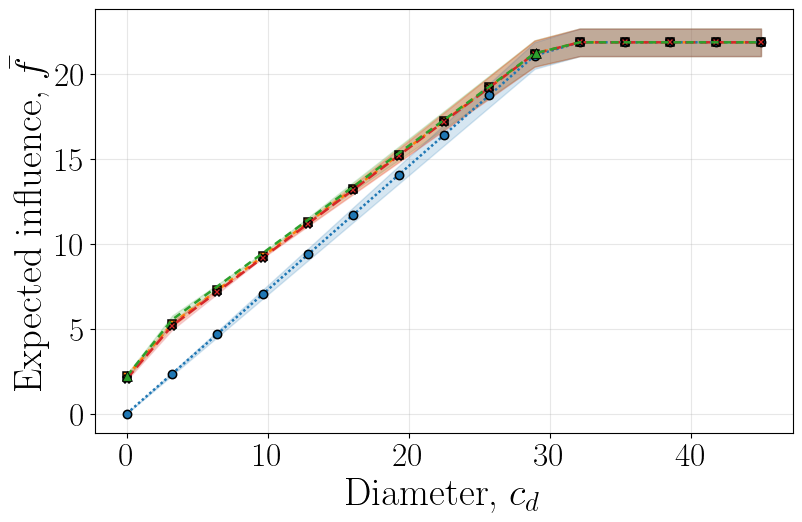

2026-02-04 20:22:02,038 |INFO: Runtime summary (mean ± std, seconds):
  - ParetoGreedy-Diameter: 0.228 ± 0.001
  - PlainGreedy: 11.718 ± 0.296
  - TopK-degree: 0.105 ± 0.002
  - PruneGraph: 10.060 ± 0.130


In [4]:
# Parameters
num_samples = 10
num_runs = 2
sample_size = 300
findApproximateParetoSolutionsInfluenceGraph(G_HEPT, num_samples=num_samples, num_runs=num_runs, sample_size=sample_size, dataset_name="NetHEPT")

### NetPHY Experiments

2026-02-04 20:22:02,161 |INFO: Initialized Pareto Influence - Graph Cost Instance, Num Nodes:300
2026-02-04 20:22:02,161 |INFO: Initialized Pareto Influence - Graph Cost Instance, Num Nodes:300
2026-02-04 20:22:02,564 |INFO: GreedyThresholdDiameter finished: max_influence=117.000, runtime=0.400s
2026-02-04 20:22:02,564 |INFO: GreedyThresholdDiameter solutions: (d=0.000, infl=27.800, |S|=1); (d=0.067, infl=28.000, |S|=23); (d=0.808, infl=29.600, |S|=33); (d=1.713, infl=30.000, |S|=34); (d=57.145, infl=117.000, |S|=280)
2026-02-04 20:22:20,666 |INFO: PlainGreedyDistanceScaled finished: max_influence=117.000, runtime=18.101s
2026-02-04 20:22:20,666 |INFO: PlainGreedyDistanceScaled solutions: (d=0.000, infl=27.800, |S|=1); (d=2.713, infl=30.000, |S|=36); (d=57.145, infl=117.000, |S|=300)
2026-02-04 20:22:20,800 |INFO: TopKDistanceScaled finished: max_influence=117.000, runtime=0.133s
2026-02-04 20:22:20,800 |INFO: TopKDistanceScaled solutions: (d=0.000, infl=0.000, |S|=1); (d=57.145, infl=

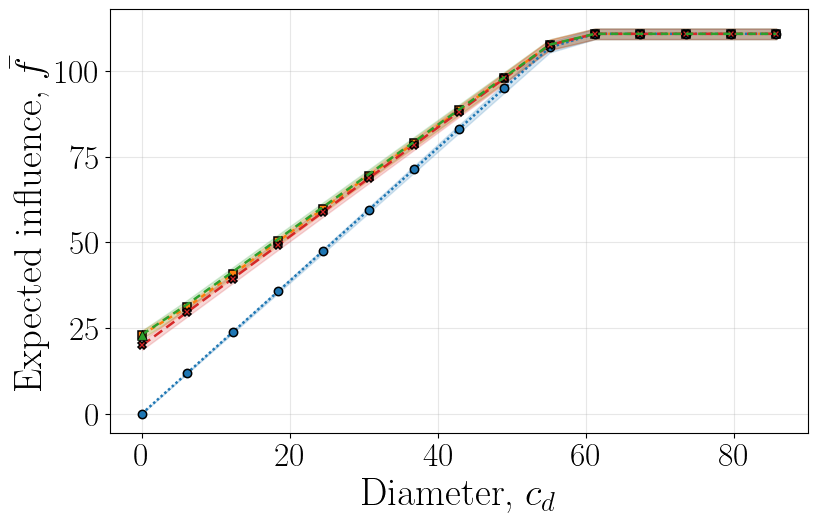

2026-02-04 20:23:16,108 |INFO: Runtime summary (mean ± std, seconds):
  - ParetoGreedy-Diameter: 0.382 ± 0.018
  - PlainGreedy: 17.564 ± 0.537
  - TopK-degree: 0.130 ± 0.002
  - PruneGraph: 18.721 ± 1.773


In [5]:
# Run for NetPHY
findApproximateParetoSolutionsInfluenceGraph(G_PHY, num_samples=num_samples, num_runs=num_runs, sample_size=sample_size, dataset_name="NetPHY")